In [1]:
%load_ext autoreload
%autoreload 2

In [160]:
import sys
from pathlib import Path
from time import time
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs, low_shelf, high_shelf
from peq import PEQ, HighShelf, LowShelf, Peaking

In [109]:
def plot_peq(peq, fr):
    fig, ax = fr.plot_graph(raw=False, smoothed=False, error=False, error_smoothed=False, target=False, equalized=False, parametric_eq=False, fixed_band_eq=False, show=False)
    for filt in peq.filters:
        ax.plot(filt.f, filt.fr, label=f'fc={filt.fc:.0f} Hz, q={filt.q:.2f}, gain={filt.gain:.2f} dB')
    ax.plot(peq.f, peq.fr, linewidth=2, label='PEQ')
    #ax.legend()
    ax.set_ylim([-15, 15])

    plt.show()

## Testing Initialization

Loss: 1.09 dB


| Type      |   Fc (Hz) |    Q |   Gain (dB) |
|-----------|-----------|------|-------------|
| LowShelf  |       105 | 0.7  |         4   |
| Peaking   |       214 | 0.67 |        -1.9 |
| Peaking   |      2004 | 1.5  |         3.5 |
| Peaking   |      5753 | 4.45 |        -7.4 |
| HighShelf |     10000 | 0.7  |        -3.7 |

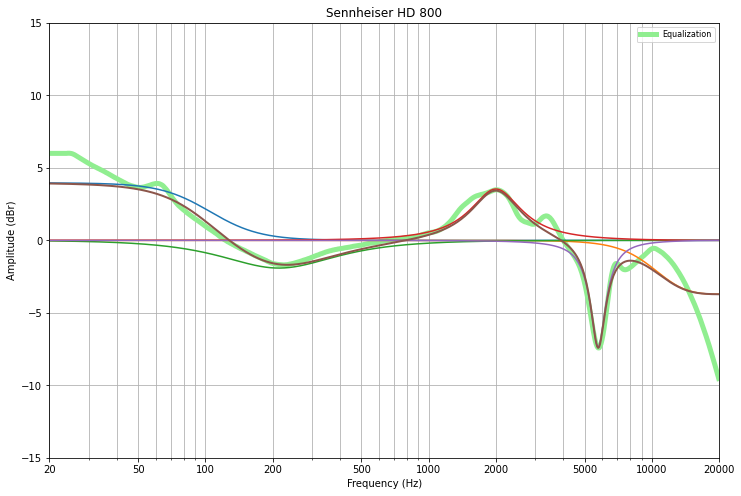

In [161]:
fr = FrequencyResponse.read_from_csv('../../results/oratory1990/harman_over-ear_2018/Sennheiser HD 800/Sennheiser HD 800.csv')
f = fr.frequency.copy()
fs = 44.1e3
peq = PEQ.from_dict({
    'fs': 44.1e3,
    'filters': [{'fc': 105, 'q': 0.7, 'type': 'LOW_SHELF'}, {'fc': 10000, 'q': 0.7, 'type': 'HIGH_SHELF'}] + [{'type': 'PEAKING'}] * 3,
}, target=fr.equalization)
init = peq._init_optimizer_params()
ix_10k = np.sum(peq.f < 10000)
print(f'Loss: {peq._optimizer_loss(init):.2f} dB')
display(Markdown(peq.markdown_table()))
plot_peq(peq, fr)

## Testing Optimization

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9532142213487298
            Iterations: 34
            Function evaluations: 414
            Gradient evaluations: 34
RMSE (f < 10 kHz): 0.33 dB


| Type      |   Fc (Hz) |    Q |   Gain (dB) |
|-----------|-----------|------|-------------|
| LowShelf  |       105 | 0.7  |         6.2 |
| Peaking   |       107 | 0.37 |        -2.4 |
| Peaking   |      1917 | 1.22 |         3.5 |
| Peaking   |      5726 | 4.35 |        -7.7 |
| HighShelf |     10000 | 0.7  |        -4.2 |

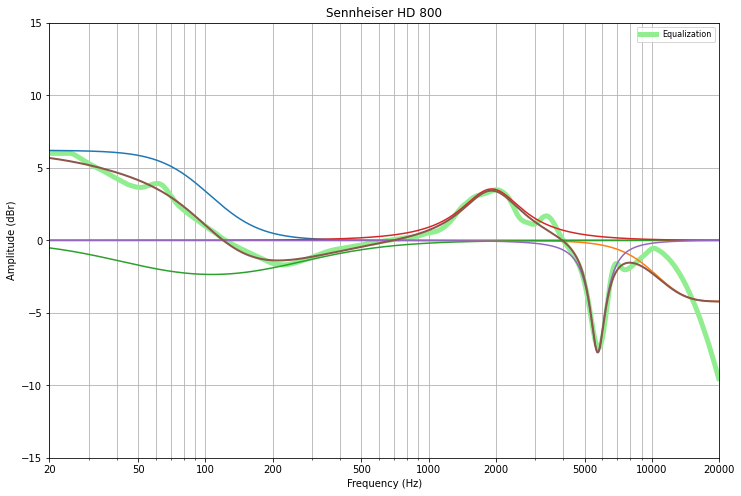

In [163]:
fr = FrequencyResponse.read_from_csv('../../results/oratory1990/harman_over-ear_2018/Sennheiser HD 800/Sennheiser HD 800.csv')

peq = PEQ.from_dict({
    'fs': 44.1e3,
    'filters': [{'fc': 105, 'q': 0.7, 'type': 'LOW_SHELF'}, {'fc': 10000, 'q': 0.7, 'type': 'HIGH_SHELF'}] +
        [{'type': 'PEAKING'}] * 3,
}, target=fr.equalization)
peq.optimize()

ix_10k = np.sum(peq.f < 10000)
print(f'RMSE (f < 10 kHz): {np.sqrt(np.mean(np.square(fr.equalization[:ix_10k] - peq.fr[:ix_10k]))):.2f} dB')
display(Markdown(peq.markdown_table()))

plot_peq(peq, fr)